In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Datasets/all_diseases.csv.gz")
df.loc[(df.disease.isin(['dengue'])) & 
       (df.no_cases.isin([-45491.0])), 
       'no_cases'] = 45491.0
df.date = pd.to_datetime(df.date)

In [3]:

# Mean Absolute Percentage Error (MAPE)
# Mean Error (ME)
# Mean Absolute Error (MAE)
# Mean Percentage Error (MPE)
# Root Mean Squared Error (RMSE)
# Lag 1 Autocorrelation of Error (ACF1)
# Correlation between the Actual and the Forecast (corr)
# Min-Max Error (minmax)



def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
#             'acf1':acf1, 
            'corr':corr, 'minmax':minmax})


In [4]:
ven_data_dengue = df[df.country.str.lower().str.contains('venezuela') &
                        df.disease.isin(['dengue'])]


ven_data_dengue.pivot_table(index=ven_data_dengue.date.dt.year, 
                               columns = ven_data_dengue.date.dt.month, 
                               values = 'no_cases', 
                               aggfunc='sum')

date,1,2,3,4,5,6,7,8,9,10,11,12
date,,,,,,,,,,,,
2015,NaN,NaN,NaN,NaN,NaN,NaN,16506.0,NaN,NaN,NaN,NaN,37646.0
2016,9407.0,4877.0,2205.0,1761.0,2283.0,2161.0,2008.0,1171.0,897.0,1166.0,800.0,532.0
2017,804.0,711.0,774.0,596.0,637.0,742.0,753.0,813.0,893.0,891.0,583.0,491.0
2018,776.0,924.0,826.0,802.0,738.0,883.0,1460.0,1638.0,3532.0,3176.0,2799.0,1672.0
2019,1296.0,950.0,691.0,591.0,857.0,1487.0,1450.0,1621.0,2296.0,1761.0,1608.0,1355.0
2020,1210.0,938.0,584.0,234.0,469.0,350.0,609.0,539.0,358.0,363.0,552.0,386.0


In [5]:
ven_data_zika = df[df.country.str.lower().str.contains('venezuela') &
                        df.disease.isin(['zika'])]


ven_data_zika.pivot_table(index=ven_data_zika.date.dt.year, 
                               columns = ven_data_zika.date.dt.month, 
                               values = 'no_cases', 
                               aggfunc='sum')

date,1,2,3,4,5,6,7,8,9,10,11,12
date,,,,,,,,,,,,
2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.0,0.0
2017,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
ven_data = df[df.country.str.lower().str.contains('venezuela')]

In [7]:
ven_data.disease.value_counts()

covid-19    557
dengue      265
zika         62
malaria      17
Name: disease, dtype: int64

## Using the auto arima for Dengue Mexico data

In [8]:
ven_data_dengue = ven_data[ven_data.disease.isin(['dengue'])]
fit_data = ven_data_dengue[['date','no_cases']]
train_data = fit_data[fit_data.date.dt.year.isin([2016,2017,2018])].set_index('date')

predict_data = fit_data[fit_data.date.dt.year.isin([2019,2020])].set_index('date')

In [9]:
from pmdarima.arima import auto_arima

In [10]:
auto_arima_model = auto_arima(train_data[['no_cases']].fillna(method="bfill"), random_state=42)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  157
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -891.890
Date:                Sun, 01 Aug 2021   AIC                           1789.780
Time:                        11:17:40   BIC                           1798.911
Sample:                             0   HQIC                          1793.489
                                - 157                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0659      0.059    -18.089      0.000      -1.181      -0.950
ma.L2          0.2798      0.067      4.178      0.000       0.149       0.411
sigma2      5726.4419    406.068     14.102      0.000    4930.562    6522.321
===================================================================================
Ljung-Box (L1) (Q):                   1.35   Jarque-Bera (JB):               121.74
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.23
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
auto_arimaprediction = pd.DataFrame(auto_arima_model.predict(len(predict_data)),index=predict_data.index)
auto_arimaprediction.columns = ['Predicted']

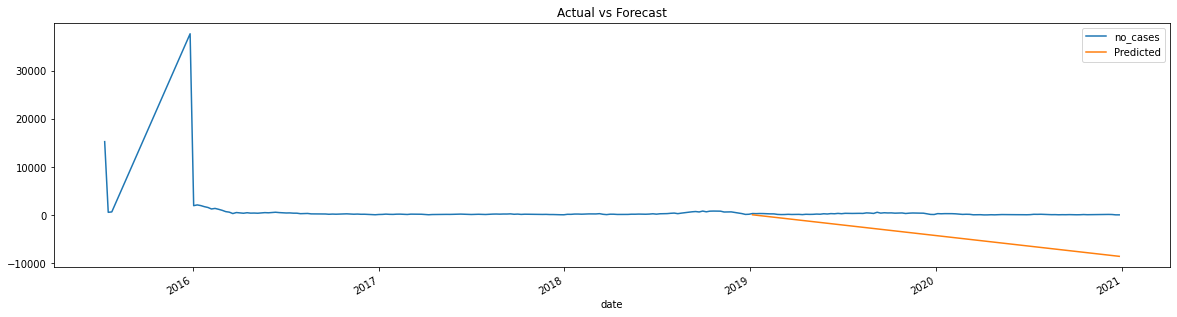

In [12]:
ax = fit_data.set_index('date').plot(y='no_cases',figsize=(20,5),title='Auto Arima Actual Vs Forecasted')
auto_arimaprediction.plot(y='Predicted',figsize=(20,5),title='Actual vs Forecast', ax=ax)

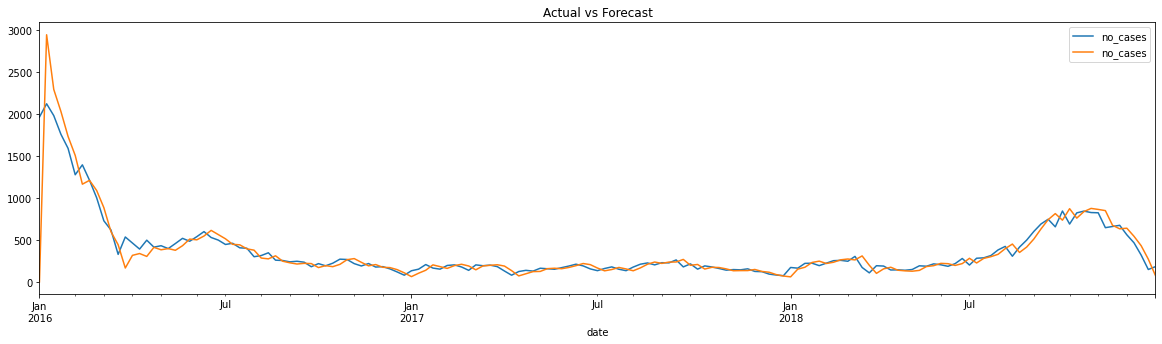

In [13]:
# Checking model fit on train data

trainfitpredict = pd.DataFrame(auto_arima_model.predict_in_sample(), index=train_data.index)
trainfitpredict.columns = ['no_cases']

ax = train_data.plot(y='no_cases',figsize=(20,5),title='Actual Vs Forecasted')
trainfitpredict.plot(y='no_cases',figsize=(20,5),title='Actual vs Forecast', ax=ax)

# Classic Arima

In [14]:
def aic_for_orders(train, pdq_values):
    train = train.astype('float32')
    ordersaic_d = {}
    for current_pdq in pdq_values:
        cur_model = ARIMA(train, order=current_pdq)
        cur_results = cur_model.fit()
        cur_aic = cur_results.aic
        ordersaic_d[current_pdq] = cur_aic
    return ordersaic_d

def get_arima_predictions(train, test, order):
    predictions = list()
    for step in range(len(test)):
        model = ARIMA(train,order=order)
        fit_model = model.fit()
        prediction = fit_model.forecast().values[0]
        timestamp = test.index[step]
        predictions.append((timestamp, prediction))
        train = train.append(test.iloc[step])
    preds_frame = pd.DataFrame(predictions).set_index([0]).rename(columns={1:'Predictions'})
    return preds_frame

In [15]:
p = d = q = range(0,4)
pdqlist = list(itertools.product(p, d, q))
newordersaic_d = aic_for_orders(train=train_data[['no_cases']].fillna(method="bfill"), pdq_values=pdqlist)

In [ ]:
orders_andaic = pd.DataFrame(newordersaic_d.items(),columns=['orders','aic']).sort_values(by='aic',ascending=True)

fig_dims = (44, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='orders', y='aic', data=orders_andaic)
ax.set(xlabel = 'orders', ylabel='%', title='pdq values and aic scores')

[Text(0, 0.5, '%'),
 Text(0.5, 0, 'orders'),
 Text(0.5, 1.0, 'pdq values and aic scores')]

In [ ]:
arima_test_predictions = get_arima_predictions(train_data[['no_cases']],
                                               predict_data[['no_cases']],
                                              order=(2,1,2))

In [ ]:
arima_test_predictions.head()

In [ ]:
fit_data[fit_data.date.dt.year.isin([2019])].head()

In [ ]:
ax = fit_data.set_index('date').plot(y='no_cases',figsize=(20,5),title='Actual Vs Forecasted')
arima_test_predictions.plot(y='Predictions',figsize=(20,5),title='Actual vs Forecast', ax=ax)

In [ ]:
forecast_accuracy(arima_test_predictions['Predictions'], predict_data['no_cases'])

# Arima model for covid

In [ ]:
ven_data_covid = ven_data[ven_data.disease.isin(['covid-19'])]

ven_data_covid.date = pd.to_datetime(ven_data_covid.date)


In [ ]:
pd.crosstab(ven_data_covid.date.dt.year, ven_data_covid.date.dt.month)

In [ ]:
fit_data = ven_data_covid[['date','no_cases']]
# train_data = fit_data[fit_data.date.dt.year.isin([2020])].set_index('date')
train_data = fit_data[fit_data.date <= pd.to_datetime('2021-06-30')].set_index('date')

predict_data = fit_data[fit_data.date >= pd.to_datetime('2021-07-01')].set_index('date')

In [ ]:
auto_arima_model = auto_arima(train_data[['no_cases']].fillna(method="bfill"), random_state=42)
auto_arima_model.summary()

In [ ]:
auto_arimaprediction = pd.DataFrame(auto_arima_model.predict(len(predict_data)),index=predict_data.index)
auto_arimaprediction.columns = ['Predicted']

ax = fit_data.set_index('date').plot(y='no_cases',figsize=(20,5),title='Auto Arima Actual Vs Forecasted')
auto_arimaprediction.plot(y='Predicted',figsize=(20,5),title='Actual vs Forecast', ax=ax)

In [ ]:
# Checking model fit on train data

trainfitpredict = pd.DataFrame(auto_arima_model.predict_in_sample(), index=train_data.index)
trainfitpredict.columns = ['no_cases']

ax = train_data.plot(y='no_cases',figsize=(20,5),title='Actual Vs Forecasted')
trainfitpredict.plot(y='no_cases',figsize=(20,5),title='Actual vs Forecast', ax=ax)

In [ ]:
p = d = q = range(0,4)
pdqlist = list(itertools.product(p, d, q))
newordersaic_d = aic_for_orders(train=train_data.no_cases, pdq_values=pdqlist)

In [ ]:
orders_andaic = pd.DataFrame(newordersaic_d.items(),columns=['orders','aic']).sort_values(by='aic',ascending=True)

fig_dims = (44, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='orders', y='aic', data=orders_andaic)
ax.set(xlabel = 'orders', ylabel='%', title='pdq values and aic scores')

In [ ]:
arima_test_predictions = get_arima_predictions(train_data[['no_cases']],
                                               predict_data[['no_cases']],
                                              order=(0,2,3))

In [ ]:
ax = fit_data.set_index('date').plot(y='no_cases',figsize=(20,5),title='Actual Vs Forecasted')
arima_test_predictions.plot(y='Predictions',figsize=(20,5),title='Actual vs Forecast', ax=ax)

In [ ]:
forecast_accuracy(arima_test_predictions['Predictions'], predict_data['no_cases'])